In [1]:
import os

import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TFHUB_CACHE_DIR"]="tfhub_modules"

torch.manual_seed(1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

class ISEARDataset(object):
  FILENAME = "data/isear_databank.csv"
  EMOTION_CLASSES = ["anger", "disgust", "fear", "guilt", "joy", "sadness", "shame"]
  EMOTION_CLASSES_DICT = {"anger": 0, "disgust": 1, "fear": 2, "guilt": 3, "joy": 4, "sadness": 5, "shame": 6}
  RANDOM_STATE = 41

  def get_classes(self):
    return self.EMOTION_CLASSES
  
  def get_classes_dict(self):
    return self.EMOTION_CLASSES_DICT

  def __init__(self):
    self.vectorizer = TfidfVectorizer()
    data = pd.read_csv(self.FILENAME)
    data["text"] = data["SIT"]
    data["emotion"] = data["Field1"]
    for emotion in self.get_classes():
      data.loc[data["emotion"] == emotion, "emotion_int"] = self.get_classes_dict()[emotion]
    self.X = self.vectorizer.fit_transform(data["text"].values).toarray()
    self.y = data["emotion_int"].values

In [3]:
isear_dataset = ISEARDataset()
X_train, X_test, y_train, y_test = train_test_split(isear_dataset.X, isear_dataset.y, test_size=0.3, random_state=isear_dataset.RANDOM_STATE, stratify=isear_dataset.y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=isear_dataset.RANDOM_STATE, stratify=y_train)

print("X_train.shape: (%d, %d)" % X_train.shape)
print("y_train.shape: (%d)" % y_train.shape)

print("X_valid.shape: (%d, %d)" % X_valid.shape)
print("y_valid.shape: (%d)" % y_valid.shape)

print("X_test.shape: (%d, %d)" % X_test.shape)
print("y_test.shape: (%d)" % y_test.shape)

X_train.shape: (4292, 8976)
y_train.shape: (4292)
X_valid.shape: (1074, 8976)
y_valid.shape: (1074)
X_test.shape: (2300, 8976)
y_test.shape: (2300)


In [4]:
dic = isear_dataset.get_classes_dict()
labels = isear_dataset.get_classes()
n_classes = len(labels)
print("class dictionary: %s" % dic)
print("class labels: %s" % labels)
print("number of bins: %s" % n_classes)

class dictionary: {'anger': 0, 'disgust': 1, 'fear': 2, 'guilt': 3, 'joy': 4, 'sadness': 5, 'shame': 6}
class labels: ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']
number of bins: 7


bins: [0, 1, 2, 3, 4, 5, 6, 7]


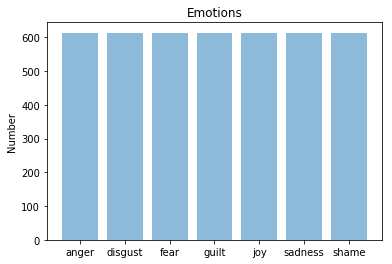

In [5]:
bins = list(range(0, n_classes + 1))
print("bins:", bins)
hist, _ = np.histogram(y_train, bins=bins)

y_pos = np.arange(len(labels))

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

In [6]:
from torch import autograd

def make_one_hot(labels, C=2):
    '''
    Converts an integer label torch.autograd.Variable to a one-hot Variable.
    
    Parameters
    ----------
    labels : torch.autograd.Variable of torch.cuda.LongTensor
        N x 1 x H x W, where N is batch size. 
        Each value is an integer representing correct classification.
    C : integer. 
        number of classes in labels.
    
    Returns
    -------
    target : torch.autograd.Variable of torch.cuda.FloatTensor
        N x C x H x W, where C is class number. One-hot encoded.
    '''
    one_hot = torch.FloatTensor(labels.size(0), C, labels.size(2), labels.size(3)).zero_()
    target = one_hot.scatter_(1, labels.data, 1)
    
    target = autograd.Variable(target)
        
    return target
  
y = torch.LongTensor(y_train).view(-1, 1, 1, 1)
print("y.shape:", y.shape)
y_onehot = make_one_hot(y, C=7)
print("y_onehot.shape:", y_onehot.shape)

y.shape: torch.Size([4292, 1, 1, 1])
y_onehot.shape: torch.Size([4292, 7, 1, 1])


In [7]:
import torch
from torch.utils import data

class ISEAR_Tensor_Dataset(data.TensorDataset):
  
  def __init__(self, text, emotion, num_class=2):
    X = torch.tensor(text.astype('float32'))
    y = torch.LongTensor(emotion).view(-1, 1, 1, 1)
    y_onehot = make_one_hot(y, num_class)
    y_onehot = y_onehot.view(y_onehot.shape[0], y_onehot.shape[1])
    tensors = []
    tensors.append(X)
    tensors.append(y_onehot)
    super().__init__(*tensors)

In [8]:
train_dataset = ISEAR_Tensor_Dataset(X_train, y_train, num_class=7)
valid_dataset = ISEAR_Tensor_Dataset(X_valid, y_valid, num_class=7)
test_dataset = ISEAR_Tensor_Dataset(X_test, y_test, num_class=7)

In [9]:
print("train_dataset.tensors[0].shape:", train_dataset.tensors[0].shape)
print("train_dataset.tensors[1].shape:", train_dataset.tensors[1].shape)

train_dataset.tensors[0].shape: torch.Size([4292, 8976])
train_dataset.tensors[1].shape: torch.Size([4292, 7])


In [10]:
print("train_dataset length:", len(train_dataset))
print("valid_dataset length:", len(valid_dataset))
print("test_dataset length:", len(test_dataset))

train_dataset length: 4292
valid_dataset length: 1074
test_dataset length: 2300


In [11]:
batch_size = 10

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Neural Network Architecture 

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class DNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(DNNModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.linear_input = nn.Linear(input_dim, hidden_dim)
        self.linear_hidden_1 = nn.Linear(hidden_dim, hidden_dim)
        self.linear_hidden_2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear_output = nn.Linear(hidden_dim, output_dim)
        self.linear_threshold = nn.Linear(hidden_dim, hidden_dim)
        self.linear_threshold_output = nn.Linear(hidden_dim, 1)

        self.dropout = dropout

    def forward(self, x):
        tmp = F.dropout(F.relu(self.linear_input(x)), self.dropout)
        out = F.dropout(F.relu(self.linear_hidden_1(tmp)), self.dropout)
        out = F.dropout(F.relu(self.linear_hidden_2(out)), self.dropout)
        out = F.sigmoid(self.linear_output(tmp))

        tmp = F.dropout(F.relu(self.linear_threshold(tmp)), self.dropout)
        threshold = F.sigmoid(self.linear_threshold_output(tmp))

        return out, threshold

In [13]:
input_dim = train_dataset.tensors[0].shape[1]
hidden_dim = 500
output_dim = train_dataset.tensors[1].shape[1]
dropout = 0.5
batch_size = 10
model = DNNModel(input_dim, hidden_dim, output_dim, dropout=dropout)
model = model.to(device)

In [14]:
train_loader.__dict__

{'dataset': <__main__.ISEAR_Tensor_Dataset at 0x7fb9a7ad1cc0>,
 'batch_size': 10,
 'num_workers': 0,
 'collate_fn': <function torch.utils.data.dataloader.default_collate(batch)>,
 'pin_memory': False,
 'drop_last': False,
 'timeout': 0,
 'worker_init_fn': None,
 'sampler': <torch.utils.data.sampler.RandomSampler at 0x7fb9a0b1f160>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x7fb9a0b1f198>,
 '_DataLoader__initialized': True}

In [15]:
def train(epoch, model, data_loader, device, optimiser, loss_fn=nn.BCELoss(), log_interval=100):
    #####################
    # Train model
    #####################

    # switch model to training mode, clear gradient accumulators
    model.train()

    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        optimiser.zero_grad()

        output, threshold = model(data)

        loss = loss_fn(output, target)
        loss.backward()
        optimiser.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}\t/\t{}\t({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    return loss.item()

In [16]:
def evaluate(model, data_loader, device, loss_fn=nn.BCELoss()):
    #####################
    # Evaluation model
    #####################
    model.eval()
    eval_loss = 0
    total_correct = 0

    all_pred = []
    all_target = []

    with torch.no_grad():

        # for batch_idx, (data, target) in enumerate(data_loader):
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output, threshold = model(data)

            loss = loss_fn(output, target).data # sum up batch loss
            eval_loss += loss

            pred = output.max(1, keepdim=True)[1]
            pred = pred.view(pred.size(0))

            target = target.max(1, keepdim=True)[1]
            target = target.view(target.size(0))

            correct = pred.eq(target.view_as(pred)).sum()
            total_correct += correct

            all_pred += pred.cpu().numpy().tolist()
            all_target += target.cpu().numpy().tolist()

    eval_loss /= len(test_loader.dataset)

    print('\nEvaluate: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        eval_loss, total_correct, len(test_loader.dataset),
        100. * total_correct / len(test_loader.dataset)))

    return eval_loss, all_pred, all_target

In [17]:
loss_fn = nn.BCELoss()
log_interval = 10
max_epochs = 10
learning_rate = 1e-3
optimiser = optim.Adam(model.parameters(), lr=learning_rate)

hist = np.zeros(max_epochs)
eval_hist = np.zeros(max_epochs)

for epoch in range(max_epochs):
  
    hist[epoch] = train(epoch, model, train_loader, device, optimiser, loss_fn, log_interval)
    
    valid_loss, valid_pred, valid_target = evaluate(model, valid_loader, device, loss_fn=nn.BCELoss())
    eval_hist[epoch] = valid_loss

/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 0 [0	/	4292	(0%)]	Loss: 0.693691
Train Epoch: 0 [1000	/	4292	(23%)]	Loss: 0.420553
Train Epoch: 0 [2000	/	4292	(47%)]	Loss: 0.395466
Train Epoch: 0 [3000	/	4292	(70%)]	Loss: 0.369814
Train Epoch: 0 [4000	/	4292	(93%)]	Loss: 0.357362

Evaluate: Average loss: 0.0169, Accuracy: 528/2300 (22%)

Train Epoch: 1 [0	/	4292	(0%)]	Loss: 0.312903
Train Epoch: 1 [1000	/	4292	(23%)]	Loss: 0.309004
Train Epoch: 1 [2000	/	4292	(47%)]	Loss: 0.336583
Train Epoch: 1 [3000	/	4292	(70%)]	Loss: 0.260885
Train Epoch: 1 [4000	/	4292	(93%)]	Loss: 0.190482

Evaluate: Average loss: 0.0138, Accuracy: 576/2300 (25%)

Train Epoch: 2 [0	/	4292	(0%)]	Loss: 0.185142
Train Epoch: 2 [1000	/	4292	(23%)]	Loss: 0.208540
Train Epoch: 2 [2000	/	4292	(47%)]	Loss: 0.249808
Train Epoch: 2 [3000	/	4292	(70%)]	Loss: 0.135362
Train Epoch: 2 [4000	/	4292	(93%)]	Loss: 0.193990

Evaluate: Average loss: 0.0132, Accuracy: 588/2300 (25%)

Train Epoch: 3 [0	/	4292	(0%)]	Loss: 0.080709
Train Epoch: 3 [1000	/	4292	(23%)]	Loss

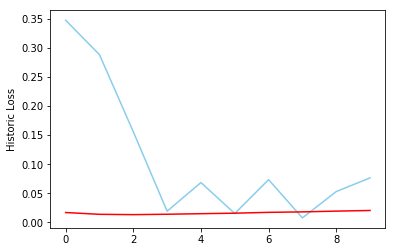

In [18]:
import matplotlib.pyplot as plt
plt.plot(hist, color='skyblue')
plt.plot(eval_hist, color='red')
plt.ylabel('Historic Loss')
plt.show()

In [19]:
test_loss, test_pred, test_target = evaluate(model, test_loader, device, loss_fn)


Evaluate: Average loss: 0.0439, Accuracy: 1183/2300 (51%)



In [20]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

cf_matrix = confusion_matrix(test_target, test_pred)

df_cm = pd.DataFrame(
    cf_matrix, index=labels, columns=labels, 
)

df_cm

,anger,disgust,fear,guilt,joy,sadness,shame
anger,113,37,18,71,17,21,52
disgust,42,174,16,30,12,12,43
fear,18,16,200,24,18,21,31
guilt,45,24,13,149,15,24,58
joy,13,8,10,23,226,18,30
sadness,35,10,26,26,32,171,29
shame,34,34,23,52,24,12,150


In [21]:
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (4,3), fontsize=15):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

Figure(288x216)


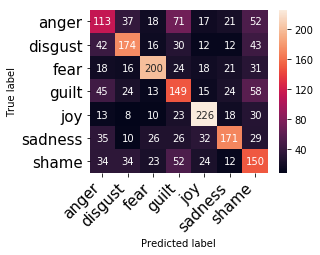

In [22]:
print(print_confusion_matrix(cf_matrix, class_names=labels))

In [23]:
test_accuracy = accuracy_score(test_target, test_pred)
print("test accuracy:", test_accuracy)

test accuracy: 0.5143478260869565


### Performance score for each classes

In [24]:
precision, recall, fscore, support = precision_recall_fscore_support(test_target, test_pred)
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support.round(4)
}
score_df = pd.DataFrame(score_dict, index=labels)
score_df

,precision,recall,f1-score,support
anger,0.3767,0.3435,0.3593,329
disgust,0.5743,0.5289,0.5506,329
fear,0.6536,0.6098,0.6309,328
guilt,0.3973,0.4543,0.4239,328
joy,0.6570,0.6890,0.6726,328
sadness,0.6129,0.5198,0.5625,329
shame,0.3817,0.4559,0.4155,329


### Cohen Kappa Score

In [27]:
from sklearn.metrics import cohen_kappa_score

kappa_score = cohen_kappa_score(test_target, test_pred)
print("kappa:", kappa_score)

kappa: 0.43341070611391996
